In [8]:
# TODO get labels thats is from the return ratio, somebody do that, just a sliding window just like mvavg.
# Update = Done. Someone forgot to save the code for this, not pointing fingers (tho im looking at Samriddha.).
import os
import pandas as pd
file_path=r'./Data_is_here'
files=os.listdir(file_path)
for file in files:
    df=pd.read_csv(file_path+'/'+file)
    # print(df['Return Ratio'])
    # break
    print(file)
    df['Stock_Movement_Label']=(df['Return Ratio'][5:]>0).astype(int)
    df.to_csv(file_path+'/'+file)

COCHINSHIP_data.csv
MANAPPURAM_data.csv
RVNL_data.csv
MFSL_data.csv
SBIN_data.csv
BLUESTARCO_data.csv
J&KBANK_data.csv
COLPAL_data.csv
WESTLIFE_data.csv
GLENMARK_data.csv
CENTURYPLY_data.csv
ABREL_data.csv
UJJIVANSFB_data.csv
EIDPARRY_data.csv
EIHOTEL_data.csv
WIPRO_data.csv
HINDZINC_data.csv
JINDALSTEL_data.csv
CHOLAFIN_data.csv
INDUSINDBK_data.csv
VIPIND_data.csv
JYOTHYLAB_data.csv
TATAINVEST_data.csv
BATAINDIA_data.csv
FORTIS_data.csv
AJANTPHARM_data.csv
FEDERALBNK_data.csv
TCS_data.csv
ALKYLAMINE_data.csv
VGUARD_data.csv
INDIGO_data.csv
AXISBANK_data.csv
SONATSOFTW_data.csv
TATAPOWER_data.csv
GUJGASLTD_data.csv
M&M_data.csv
BIRLACORPN_data.csv
BHARTIARTL_data.csv
GODREJIND_data.csv
PRESTIGE_data.csv
HONAUT_data.csv
KAJARIACER_data.csv
ASHOKLEY_data.csv
POLYMED_data.csv
NLCINDIA_data.csv
UNIONBANK_data.csv
HSCL_data.csv
ICICIPRULI_data.csv
FACT_data.csv
EXIDEIND_data.csv
APOLLOHOSP_data.csv
PETRONET_data.csv
SAMMAANCAP_data.csv
ZYDUSLIFE_data.csv
JKLAKSHMI_data.csv
INDIAMART_data.cs

KeyboardInterrupt: 

In [12]:
%pip install torch-geometric

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import torch
import pandas as pd
file_path=r'./Data_is_here'
save_path = r'./Preprocessed_data'
os.makedirs(save_path, exist_ok=True)
def set_data(file):
    df=pd.read_csv(file_path+'/'+file)
    df.fillna(0,inplace=True)
    # Assuming the dataframe is loaded into `df`
    # Drop the first two rows (metadata rows)
    df = df.iloc[2:].reset_index(drop=True)
    df.columns = [
        "Index", "Date", 
        "Close", "High", "Low", "Open", 
        "Volume",
        "MA_5", "MA_15", "MA_10", "MA_20", "MA_25", "MA_30", 
        "Normalized_Close",
        "Return_Ratio", "Percentage_Change_Open", "Percentage_Change_High", "Percentage_Change_Low", 
        "Sector", 
        "Sector_Encoded", 
        "Stock_Movement_Label"
    ]
    df = df.drop(columns=["Index","Date","Sector","Volume","Normalized_Close","Stock_Movement_Label"])
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna().reset_index(drop=True)
    df.to_csv(save_path+'/'+file)
    # print(df.describe())

for file in os.listdir(file_path):
    set_data(file)

COme back and chnage this here if the parametres are 15 and not 17 

In [55]:
import os
import torch
import pandas as pd
file_path=r'./Preprocessed_data'
def get_embeddings(file):
    df = pd.read_csv(file_path+'/'+file)
    df.reset_index(drop=True, inplace=True)
    df = df.drop(['Unnamed: 0'],axis=1)
    # print(df.describe())
    output_dir = os.path.join('./', "raw_embeddings")
    csv_dir = os.path.join('./', "raw_embeddings_csv")
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(csv_dir, exist_ok=True)
    all_tensors = []
    for i in range(len(df) - 5 + 1):
        # print(df[i:i + 5])
        # break
        tensor = torch.from_numpy(df[i:i + 5].values).float()
        all_tensors.append(tensor)
    all_tensors = torch.stack(all_tensors)  # Shape = (num_tensors, 5, num_columns)
    print(all_tensors.shape)
    tensor_file = os.path.join(output_dir, f"{file[:-4]}_raw_embeddings.pt")
    torch.save(all_tensors, tensor_file)
    # This(the csv part) not required idk what i was thinking
    # csv_file = os.path.join(csv_dir, f"{file[:-4]}_raw_embeddings.csv")
    # flattened_tensors = all_tensors.view(all_tensors.size(0), -1).numpy()  # Shape = (num_tensors, 5*num_columns)
    # pd.DataFrame(flattened_tensors).to_csv(csv_file, index=False)
    
    # print(f"Embeddings .csv saved in:\n- {tensor_file}\n- {csv_file}")
    print(f"Embeddings .pt saved in {output_dir}")

for file in os.listdir(file_path):
    get_embeddings(file)
    # break

torch.Size([1234, 5, 15])
Embeddings .pt saved in ./raw_embeddings
torch.Size([1234, 5, 15])
Embeddings .pt saved in ./raw_embeddings
torch.Size([1234, 5, 15])
Embeddings .pt saved in ./raw_embeddings
torch.Size([1234, 5, 15])
Embeddings .pt saved in ./raw_embeddings
torch.Size([1234, 5, 15])
Embeddings .pt saved in ./raw_embeddings
torch.Size([1234, 5, 15])
Embeddings .pt saved in ./raw_embeddings
torch.Size([1234, 5, 15])
Embeddings .pt saved in ./raw_embeddings
torch.Size([1234, 5, 15])
Embeddings .pt saved in ./raw_embeddings
torch.Size([1234, 5, 15])
Embeddings .pt saved in ./raw_embeddings
torch.Size([1234, 5, 15])
Embeddings .pt saved in ./raw_embeddings
torch.Size([1234, 5, 15])
Embeddings .pt saved in ./raw_embeddings
torch.Size([1234, 5, 15])
Embeddings .pt saved in ./raw_embeddings
torch.Size([1234, 5, 15])
Embeddings .pt saved in ./raw_embeddings
torch.Size([1234, 5, 15])
Embeddings .pt saved in ./raw_embeddings
torch.Size([1234, 5, 15])
Embeddings .pt saved in ./raw_embedd

In [3]:
batch_size = 1
seq_len = 5
input_size = 15
hidden_size = 16

x = torch.randn(batch_size, seq_len, input_size)  # Shape = (1, 5, 15)
# Forward pass
embeded = SequenceEncoder(input_size, seq_len, hidden_size)(x)
print(embeded.shape)  # Shape = (1, 16)

torch.Size([1, 64])


#### NOTE, that the features has changed from 15 to 17 so adjust accoerdingly

In [8]:
import torch

# from FinancialGraphAttentionmaster.model.graph_pool import SequenceEncoder as se


def get_Ai(week_seq_i, time_step = 5,input_size=15, hidden_size=16):
    #  Vi is the data from the week of shape (1,5,15) extra 1 is for the batch dimension
    # hi_prev is the hidden state from the previous week of shape (1,1,16)
    # TODO add a check for this if you want and to also check if week_seq_i are torch.tensors if not convert them
    
    encoder = SequenceEncoder(input_dim=input_size, time_step=time_step, hidden_dim=hidden_size)
    ai = encoder(week_seq_i)
    return ai
    

In [3]:
# This is a test for Encoder block
batch_size = 1
time_step = 5 # Days
input_dim = 15 # Features
hidden_dim = 16 # Hidden dimension specified in the paper as {8, 16, 32, 16}
                # thats what it said this is how i interpreted it

seq = torch.randn(batch_size, time_step, input_dim)

a1 = get_Ai(seq[0].unsqueeze(0), time_step, input_dim, hidden_dim)
print(a1.shape)


NameError: name 'get_Ai' is not defined

In [35]:
# TODO Make the Adjacency Matrix of everything. Update = This is Done

# OK heres how im going to impelemnt it if u have a better version please come ahead why am i even writing this is its not like anyones going to read this anyway 
# welp just in case you do read it this is how im making it im making a string dict whre the key is the node and the values are the neighbours
# then when we want to acess the Ai list for each stcok we can just use a HashMap to do so.
import os
import pandas as pd
sector_mat = dict() ### GLOBAL VAR

file_path = './Preprocessed_data'
for file in os.listdir(file_path):
    df = pd.read_csv(file_path+"/"+file)
    # print(df.info)
    sector = df['Sector_Encoded'][0]
    if sector in sector_mat:
        sector_mat[sector].append(file[:-9])
    else:
        sector_mat[sector] = [file[:-9]]

sector_mat = {k: v for k, v in sector_mat.items() if len(v)>1}
for v in sector_mat.values():
    print(len(v),v)

51 ['COCHINSHIP', 'HONAUT', 'ASHOKLEY', 'AIAENG', 'FINPIPE', 'POLYCAB', 'BEL', 'THERMAX', 'SUZLON', 'APARINDS', 'GRAPHITE', 'HEG', 'ACE', 'PRAJIND', 'MAHSEAMLES', 'SIEMENS', 'APLAPOLLO', 'USHAMART', 'RHIM', 'JINDALSAW', 'KEI', 'BHEL', 'TITAGARH', 'SCHNEIDER', 'BDL', 'JWL', 'ABB', 'CARBORUNIV', 'KIRLOSBROS', 'GRINDWELL', 'ELECON', 'TIMKEN', 'ELGIEQUIP', 'KIRLOSENG', 'BEML', 'CGPOWER', 'ESCORTS', 'CUMMINSIND', 'FINCABLES', 'WELCORP', 'GRSE', 'KSB', 'ASTRAL', 'INOXWIND', 'RATNAMANI', 'SKFINDIA', 'GPIL', 'SUPREMEIND', 'TRITURBINE', 'GVT&D', 'HAL']
72 ['MANAPPURAM', 'MFSL', 'SBIN', 'J&KBANK', 'UJJIVANSFB', 'CHOLAFIN', 'INDUSINDBK', 'TATAINVEST', 'FEDERALBNK', 'AXISBANK', 'UNIONBANK', 'ICICIPRULI', 'SAMMAANCAP', 'BAJFINANCE', 'SUNDARMFIN', 'HDFCAMC', 'INDIANB', 'IOB', 'HDFCLIFE', 'ISEC', 'BSE', '360ONE', 'SHRIRAMFIN', 'BAJAJHLDNG', 'AUBANK', 'MCX', 'PNB', 'AAVAS', 'KOTAKBANK', 'ABCAPITAL', 'LTF', 'MOTILALOFS', 'NIACL', 'NAM-INDIA', 'YESBANK', 'PFC', 'JMFINANCIL', 'GICRE', 'BAJAJFINSV', 'PEL'

In [ ]:
# TODO Create the Graphs that is going to create the sector graphs and and then we need to create these graphs for like
# Ai and Gi also like per week
# Update = Made it. Excpet the HasMap to link this to the Ai list and the Gi list cause we dont have that yet.

name_matrix = dict()
for same_sector_stocks in sector_mat.values():
    for stock_key in same_sector_stocks:
        name_matrix[stock_key] = []
        for stock_value in same_sector_stocks:
            if stock_value != stock_key:
                name_matrix[stock_key].append(stock_value)

for key,value in name_matrix.items():
    print(key,value)

# TODO Create HashMap to acess the Ai list for the given names


COCHINSHIP ['HONAUT', 'ASHOKLEY', 'AIAENG', 'FINPIPE', 'POLYCAB', 'BEL', 'THERMAX', 'SUZLON', 'APARINDS', 'GRAPHITE', 'HEG', 'ACE', 'PRAJIND', 'MAHSEAMLES', 'SIEMENS', 'APLAPOLLO', 'USHAMART', 'RHIM', 'JINDALSAW', 'KEI', 'BHEL', 'TITAGARH', 'SCHNEIDER', 'BDL', 'JWL', 'ABB', 'CARBORUNIV', 'KIRLOSBROS', 'GRINDWELL', 'ELECON', 'TIMKEN', 'ELGIEQUIP', 'KIRLOSENG', 'BEML', 'CGPOWER', 'ESCORTS', 'CUMMINSIND', 'FINCABLES', 'WELCORP', 'GRSE', 'KSB', 'ASTRAL', 'INOXWIND', 'RATNAMANI', 'SKFINDIA', 'GPIL', 'SUPREMEIND', 'TRITURBINE', 'GVT&D', 'HAL']
HONAUT ['COCHINSHIP', 'ASHOKLEY', 'AIAENG', 'FINPIPE', 'POLYCAB', 'BEL', 'THERMAX', 'SUZLON', 'APARINDS', 'GRAPHITE', 'HEG', 'ACE', 'PRAJIND', 'MAHSEAMLES', 'SIEMENS', 'APLAPOLLO', 'USHAMART', 'RHIM', 'JINDALSAW', 'KEI', 'BHEL', 'TITAGARH', 'SCHNEIDER', 'BDL', 'JWL', 'ABB', 'CARBORUNIV', 'KIRLOSBROS', 'GRINDWELL', 'ELECON', 'TIMKEN', 'ELGIEQUIP', 'KIRLOSENG', 'BEML', 'CGPOWER', 'ESCORTS', 'CUMMINSIND', 'FINCABLES', 'WELCORP', 'GRSE', 'KSB', 'ASTRAL', '

In [10]:
import os
import torch
import pandas as pd

def read_raw_embeddings(file_path, file_name):
    tensor_file = f"{file_path}/{file_name}_raw_embeddings.pt"
    embeddings_tensor = torch.load(tensor_file)
    print(f"Loaded tensor embeddings with shape = {embeddings_tensor.shape}")
    
    return embeddings_tensor

em_path = './raw_embeddings'
file_name = '3MINDIA_data'
embeddings_tensor = read_raw_embeddings(em_path, file_name)

hashmap_Ai = dict()
n_Ais = embeddings_tensor.shape[0]
file_path = './Data_is_here'
for file in os.listdir(file_path):
    hashmap_Ai[file[:-9]] = torch.ones(size = (n_Ais, 16)) # 16 Hidden dims

for key, value in hashmap_Ai.items():
    print(f"Key = {key}, Value = {value.shape}")

# Got to store the Ais in this hashmap ok?

Loaded tensor embeddings with shape = torch.Size([1234, 5, 17])
Key = COCHINSHIP, Value = torch.Size([1234, 64])
Key = MANAPPURAM, Value = torch.Size([1234, 64])
Key = RVNL, Value = torch.Size([1234, 64])
Key = MFSL, Value = torch.Size([1234, 64])
Key = SBIN, Value = torch.Size([1234, 64])
Key = BLUESTARCO, Value = torch.Size([1234, 64])
Key = J&KBANK, Value = torch.Size([1234, 64])
Key = COLPAL, Value = torch.Size([1234, 64])
Key = WESTLIFE, Value = torch.Size([1234, 64])
Key = GLENMARK, Value = torch.Size([1234, 64])
Key = CENTURYPLY, Value = torch.Size([1234, 64])
Key = ABREL, Value = torch.Size([1234, 64])
Key = UJJIVANSFB, Value = torch.Size([1234, 64])
Key = EIDPARRY, Value = torch.Size([1234, 64])
Key = EIHOTEL, Value = torch.Size([1234, 64])
Key = WIPRO, Value = torch.Size([1234, 64])
Key = HINDZINC, Value = torch.Size([1234, 64])
Key = JINDALSTEL, Value = torch.Size([1234, 64])
Key = CHOLAFIN, Value = torch.Size([1234, 64])
Key = INDUSINDBK, Value = torch.Size([1234, 64])
Key 

/var/folders/tq/snmht7dn5_71h91dhlsnsz8m0000gn/T/ipykernel_77776/1937941431.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings_tensor = torch.load(tensor_file)


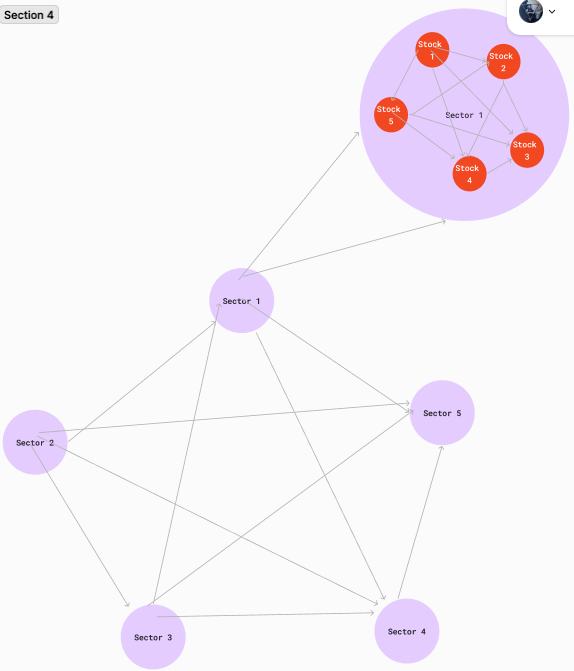

#### How the Adj Matrix looks or atleast this is what i think it looks it to my understanding a bit different from what the paper is doing, atleast thats what the GAT in the code he sent is using.

#### There are like 3 models in the repo the most basic one is used below, we should probably make this better.

In [ ]:
# TODO cluster up the same sector stocks make sure that Ai are stored in an
# adjacency matrix as specifed in the paper this is along raw Ai will be the input for GAT

# Update = Made it. Except the HashMap which has to be done with the Running you can make a skeleton code
# tho i think it will be better to be done then? or maybe im just being lazy

# from FinancialGraphAttentionmaster.model.graph_pool import CategoricalGraph as gat

def get_gi(ai_sq, ai_sn):
    # ai_sq Ai for a stock of week i
    gat_encoder = GAT(in_dim = 16, out_dim=16)
    gi = gat_encoder(ai_sq, ai_sn)
    return gi




In [ ]:
# Long Term Sequential Learning with Short Term Embeddings
# Input is the Ai of all stocks and Gi of all stocks
def get_T_i(ai_sq_list, gi_sq_list, input_dim=16, hidden_size=64, t=5):
    # ai_sq_list is the list of Ai for all weeks of a stock
    # gi_sq_list is the list of Gi for all weeks of a stock
    
    T_Ai_encoder = AttentionBlock(input_dim=input_dim, hidden_dim=hidden_size, time_step=t)
    T_Gi_encoder = AttentionBlock(input_dim=input_dim, hidden_dim=hidden_size, time_step=t)
    
    T_ai_long_term = []
    T_gi_long_term = []
    
    for i in range(t, len(ai_sq_list)):
        U_Ai = torch.stack(ai_sq_list[i-t:i])  # Shape = (t, input_dim)
        U_Gi = torch.stack(gi_sq_list[i-t:i])  # Shape = (t, input_dim)
        
        ti_ai = T_Ai_encoder(U_Ai)  # Shape = (t,)
        ti_gi = T_Gi_encoder(U_Gi)  # Shape = (t,)
        
        T_ai_long_term.append(ti_ai.sum(dim=0))  # Shape = (input_dim,)
        T_gi_long_term.append(ti_gi.sum(dim=0))  # Shape = (input_dim,)
    
    T_ai_long_term = torch.stack(T_ai_long_term)  # Shape = (num_windows, input_dim)
    T_gi_long_term = torch.stack(T_gi_long_term)  # Shape = (num_windows, input_dim)
    
    return T_ai_long_term, T_gi_long_term

In [27]:
# Sector Graph

def max_pool_sector_embeddings(data):
    data = torch.stack(data)
    return torch.max(data, dim=0)[0]


In [1]:
#RUN THIS

import torch
import torch.nn as nn

'''
Attentive GRU
Takes in raw week information and then makes Ai for all of the weeks for all the stocks (if bacthed)
'''

class AttentionBlock(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionBlock, self).__init__()
        self.fc = nn.Linear(hidden_dim, 1)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        """
        x: torch.tensor (batch_size, time_step, hidden_dim)
        """
        attention_scores = self.fc(x)  # Shape = (batch_size, time_step, 1)
        attention_scores = self.tanh(attention_scores)
        attention_weights = self.softmax(attention_scores)  # Shape = (batch_size, time_step, 1)
        return attention_weights

class SequenceEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SequenceEncoder, self).__init__()
        self.gru1 = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.gru2 = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.attention_block = AttentionBlock(hidden_dim)
        self.dropout = nn.Dropout(0.2)
        self.hidden_dim = hidden_dim
    
    def forward(self, seq):
        """
        seq: torch.tensor (batch_size, time_step, input_dim)
        """
        seq_vector, _ = self.gru1(seq)  # Shape = (batch_size, time_step, hidden_dim)
        seq_vector, _ = self.gru2(seq_vector) # Shape = (batch_size, time_step, hidden_dim)
        seq_vector = self.dropout(seq_vector)
        
        attention_weight = self.attention_block(seq_vector)  # Shape = (batch_size, timestep, 1)
        Ai = seq_vector * attention_weight  # Shape = (batch_size, time_step, hidden_dim)
        Ai = torch.sum(Ai, dim=1)  # Shape = (batch_size, hidden_dim)
        
        return Ai

In [2]:
#RUN THIS

import torch
import torch.nn as nn

class GAT_Attention_Block(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GAT_Attention_Block, self).__init__()
        self.W = nn.Linear(in_dim, out_dim)
        self.leaky_relu = nn.LeakyReLU()
        self.u = nn.Parameter(torch.randn(out_dim * 2))
    
    def forward(self, ai_sq, ai_sn_list):
        ai_sq_proj = self.W(ai_sq)
        Beta = []
        for ai_sn in ai_sn_list:
            ai_sn_proj = self.W(ai_sn)
            concated = torch.concat((ai_sq_proj, ai_sn_proj), dim=1)
            mult = torch.matmul(self.u, concated.T)  # Resulting shape: (1, 1234)
            Beta.append(torch.exp(self.leaky_relu(mult)))
        
        Beta = torch.stack(Beta)  # Stack the list of tensors
        sum_beta = torch.sum(Beta, axis=0)
        output = torch.div(Beta, sum_beta)
        return output

class GAT(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GAT, self).__init__()
        self.attention_block = GAT_Attention_Block(in_dim, out_dim)
        self.relu = nn.ReLU()
        self.W1 = nn.Linear(in_dim, out_dim) # Im not sure of this in and out dim if you run into an error here please fix it or show it to saksham X):P
    
    def forward(self, ai_sq, ai_sn):
        ai_sn_proj = torch.stack([self.W1(ai_si) for ai_si in ai_sn])  # Shape = (len(ai_sn), out_dim)
        B = self.attention_block(ai_sq, ai_sn)  # Shape = (len(ai_sn),)
        B = B.unsqueeze(-1)  # Reshape B to (len(ai_sn), 1) for broadcasting
        ai_sn_weighted = B * ai_sn_proj  # Element-wise multiplication, Shape = (len(ai_sn), out_dim)
        ai_sn_sum = torch.sum(ai_sn_weighted, dim=0)  # Shape = (out_dim,)
        g_sq = self.relu(ai_sn_sum)  # Shape = (out_dim,)
        return g_sq

In [3]:
#RUN THIS


import torch.nn as nn
class AttentionBlockLTSL(nn.Module):
    def __init__(self, input_dim, hidden_dim, time_step):
        super(AttentionBlockLTSL, self).__init__()
        self.V = nn.Parameter(torch.randn(input_dim, hidden_dim))  # Weight matrix for u
        self.W = nn.Parameter(torch.randn(hidden_dim, 1))  # Weight matrix for transformed u
        
    def forward(self, U):
        # U: (batch_size, time_step, input_dim)
        u_transformed = torch.tanh(torch.einsum('btf,fh->bth', U, self.V))  # (batch_size, time_step, hidden_dim)
        attention_scores = torch.einsum('bth,h->bt', u_transformed, self.W.squeeze())  # (batch_size, time_step)
        attention_weights = torch.softmax(attention_scores, dim=-1)  # (batch_size, time_step)
        weighted_U = torch.einsum('bt,btf->bf', attention_weights, U)  # (batch_size, input_dim)
        return weighted_U

In [4]:
#RUN THIS


# TODO the universal map is Task 3 or 4 so im not boterhing with that right now.
# Update i guess i have to now

import torch
import torch.nn as nn
import numpy as np

class SectorEmbeddingGenerator(nn.Module):
    def __init__(self, input_dim=16, hidden_dim=16):
        super(SectorEmbeddingGenerator, self).__init__()
        self.gat = GAT(in_dim=input_dim, out_dim=hidden_dim)
    
    def forward(self, data, neighbors):
        return self.gat(data, neighbors)

class FinalLayer(nn.Module):
    def __init__(self, input_dim=16, hidden_dim=16):
        super(FinalLayer, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
    
    def forward(self, short_term_embeddings, intra_sector_embeddings, inter_sector_embeddings):
        return self.relu(self.fc(torch.concat((short_term_embeddings, intra_sector_embeddings, inter_sector_embeddings),dim=-1)))


In [5]:
#RUN THIS

import torch
import torch.nn as nn
import torch.nn.functional as F

class StockPredictionLoss(nn.Module):
    def __init__(self, delta: float = 0.5, lambda_reg: float = 1e-4):
        """
        Initialize the Stock Prediction Loss.

        Args:
            delta (float): Weighting factor between L_rank and L_move.
            lambda_reg (float): Regularization coefficient for L2 penalty.
        """
        super(StockPredictionLoss, self).__init__()
        self.delta = delta
        self.lambda_reg = lambda_reg

    def forward(self, tau_F, e1, e2, b1, b2, y_return, y_move, mask=None):
        """
        Compute the loss.

        Args:
            tau_F (torch.Tensor) = Output from FinalLayer
            e1 (torch.Tensor): Task-specific hidden vector for return ratio (shape: [d]).
            e2 (torch.Tensor): Task-specific hidden vector for movement (shape: [d]).
            b1 (torch.Tensor): Bias term for return ratio (scalar).
            b2 (torch.Tensor): Bias term for movement (scalar).
            y_return (torch.Tensor): True return ratios (shape: [batch_size]).
            y_move (torch.Tensor): True binary movement labels (shape: [batch_size]).
            mask (torch.Tensor): Optional mask for valid pairs in L_rank (shape: [batch_size, batch_size]).
        
        Returns:
            torch.Tensor: Total loss (scalar).
        """
        # 1. Compute Predictions
        y_return_pred = torch.matmul(tau_F, e1) + b1  # Shape: [batch_size]
        y_move_pred = torch.sigmoid(torch.matmul(tau_F, e2) + b2)  # Shape: [batch_size]
        
        # 2. Compute Pairwise Ranking Loss (L_rank)
        pairwise_diff_pred = y_return_pred.unsqueeze(1) - y_return_pred.unsqueeze(0)  # Shape: [batch_size, batch_size]
        pairwise_diff_true = y_return.unsqueeze(1) - y_return.unsqueeze(0)  # Shape: [batch_size, batch_size]

        # Mask invalid pairs (optional)
        if mask is not None:
            pairwise_diff_pred = pairwise_diff_pred * mask
            pairwise_diff_true = pairwise_diff_true * mask

        # Max(0, -ˆΔ × Δ)
        l_rank = F.relu(-pairwise_diff_pred * pairwise_diff_true).mean()

        # 3. Compute Binary Cross-Entropy Loss for Movement (L_move)
        l_move = F.binary_cross_entropy(y_move_pred, y_move)

        # 4. L2 Regularization
        l2_reg = torch.sum(e1**2) + torch.sum(e2**2) + b1**2 + b2**2

        # 5. Total Loss
        total_loss = (1 - self.delta) * l_rank + self.delta * l_move + self.lambda_reg * l2_reg

        return total_loss

In [ ]:
#RUN THIS


import torch
import os
raw_dict = dict()
file_path=r'./raw_embeddings'
for file in os.listdir(file_path):
    data = torch.load(file_path+f"/{file}", weights_only=True)
    raw_dict[file[:-23]] = data

import pandas as pd
sector_mat = dict() ### GLOBAL VAR

pamhsah_rotces={}
file_path = r'./Preprocessed_data'
for file in os.listdir(file_path):
    df = pd.read_csv(file_path+"/"+file)
    # print(df.info)
    sector = df['Sector_Encoded'][0]
    pamhsah_rotces[file]=sector
    if sector in sector_mat:
        sector_mat[sector].append(file[:-9])
    else:
        sector_mat[sector] = [file[:-9]]
sector_mat = {k: v for k, v in sector_mat.items() if len(v)>1}

name_matrix = dict()
for same_sector_stocks in sector_mat.values():
    for stock_key in same_sector_stocks:
        name_matrix[stock_key] = []
        for stock_value in same_sector_stocks:
            if stock_value != stock_key:
                name_matrix[stock_key].append(stock_value)

inter_sector_matrix = dict()
for sector in sector_mat.keys():
    inter_sector_matrix[sector]=[]
    for other_sector in sector_mat.keys():
        if(sector!=other_sector):
            inter_sector_matrix[sector].append(other_sector)
for k,v in inter_sector_matrix.items():
    print(k,v)


    # for stock_key in same_sector_stocks:
    #     name_matrix[stock_key] = []
    #     for stock_value in same_sector_stocks:
    #         if stock_value != stock_key:
    #             name_matrix[stock_key].append(stock_value)

# for key,value in name_matrix.items():
#     print(key,value)



1.0 [9.0, 3.0, 5.0, 8.0, 6.0, 11.0, 2.0, 12.0, 14.0, 18.0, 16.0, 15.0, 0.0, 4.0, 19.0, 7.0, 17.0, 20.0, 13.0]
9.0 [1.0, 3.0, 5.0, 8.0, 6.0, 11.0, 2.0, 12.0, 14.0, 18.0, 16.0, 15.0, 0.0, 4.0, 19.0, 7.0, 17.0, 20.0, 13.0]
3.0 [1.0, 9.0, 5.0, 8.0, 6.0, 11.0, 2.0, 12.0, 14.0, 18.0, 16.0, 15.0, 0.0, 4.0, 19.0, 7.0, 17.0, 20.0, 13.0]
5.0 [1.0, 9.0, 3.0, 8.0, 6.0, 11.0, 2.0, 12.0, 14.0, 18.0, 16.0, 15.0, 0.0, 4.0, 19.0, 7.0, 17.0, 20.0, 13.0]
8.0 [1.0, 9.0, 3.0, 5.0, 6.0, 11.0, 2.0, 12.0, 14.0, 18.0, 16.0, 15.0, 0.0, 4.0, 19.0, 7.0, 17.0, 20.0, 13.0]
6.0 [1.0, 9.0, 3.0, 5.0, 8.0, 11.0, 2.0, 12.0, 14.0, 18.0, 16.0, 15.0, 0.0, 4.0, 19.0, 7.0, 17.0, 20.0, 13.0]
11.0 [1.0, 9.0, 3.0, 5.0, 8.0, 6.0, 2.0, 12.0, 14.0, 18.0, 16.0, 15.0, 0.0, 4.0, 19.0, 7.0, 17.0, 20.0, 13.0]
2.0 [1.0, 9.0, 3.0, 5.0, 8.0, 6.0, 11.0, 12.0, 14.0, 18.0, 16.0, 15.0, 0.0, 4.0, 19.0, 7.0, 17.0, 20.0, 13.0]
12.0 [1.0, 9.0, 3.0, 5.0, 8.0, 6.0, 11.0, 2.0, 14.0, 18.0, 16.0, 15.0, 0.0, 4.0, 19.0, 7.0, 17.0, 20.0, 13.0]
14.0 [1.0,

: 

In [ ]:
#RUN THIS


class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.gru = SequenceEncoder(15,16)
        self.g_gat = GAT(16,16)
        self.ai_encoder = AttentionBlockLTSL(input_dim=16, hidden_dim=16, time_step=5)
        self.gi_encoder = AttentionBlockLTSL(input_dim=16, hidden_dim=16, time_step=5)
    
    def get_T_i(self, ai_sq_list, gi_sq_list, input_dim=16, hidden_size=16, t=5):
        T_ai_long_term = []
        T_gi_long_term = []

        for i in range(t, len(ai_sq_list)):
            U_Ai = torch.stack([ai_sq for ai_sq in ai_sq_list[i-t:i]]).unsqueeze(0)  # Shape = (1, t, input_dim)
            U_Gi = torch.stack([gi_sq for gi_sq in gi_sq_list[i-t:i]]).unsqueeze(0)  # Shape = (1, t, input_dim)
            
            ti_ai = self.ai_encoder(U_Ai)  # Shape = (1, input_dim)
            ti_gi = self.gi_encoder(U_Gi)  # Shape = (1, input_dim)
            
            T_ai_long_term.append(ti_ai.squeeze(0))  # Remove batch dimension
            T_gi_long_term.append(ti_gi.squeeze(0))  # Remove batch dimension
        
        T_ai_long_term = torch.stack(T_ai_long_term, dim=0)  # Shape = (num_windows, input_dim)
        T_gi_long_term = torch.stack(T_gi_long_term, dim=0)  # Shape = (num_windows, input_dim)
        return T_ai_long_term, T_gi_long_term
    
    def forward(self, raw_dict, name_matrix):

        hashmapAi = dict()
        for key, data in raw_dict.items():
            hashmapAi[key] = self.gru(data)

        # adj_mat_intra_sector = name_matrix
        hashmapGi = dict()
        for name in name_matrix.keys():
            ai_sq = hashmapAi[name]
            ai_sn = []
            for sector_neighbour in name_matrix:
                ai_sn.append(hashmapAi[sector_neighbour])
            hashmapGi[name] = self.g_gat(ai_sq,ai_sn)
        
        hashmapTAi = dict()
        hashmapTGi = dict()
        for name in hashmapAi.keys():
            gi_list = hashmapGi[name]
            ai_list = hashmapAi[name]
            T_A, T_G = self.get_T_i(ai_list, gi_list)
            hashmapTAi[name] = T_A
            hashmapTGi[name] = T_G
        
        return hashmapTAi, hashmapTGi

class BatchBaseModel:
    def __init__(self, batch_size=10):
        self.base_model = BaseModel()
        self.batch_size = batch_size

    def process_embeddings(self, raw_dict, name_matrix):
        # Split raw_dict into batches
        stock_names = list(raw_dict.keys())
        batch_results1 = {}
        batch_results2 = {}
        

        for i in range(0, len(stock_names), self.batch_size):
            batch_names = stock_names[i:i+self.batch_size]
            batch_data = {name: raw_dict[name] for name in batch_names}
            
            # Create a subset of name_matrix for this batch
            batch_name_matrix = {
                name: name_matrix.get(name, [])
                for name in batch_names
            }

            # Process batch
            batch_output1, batch_output2 = self.base_model(batch_data, batch_name_matrix)
            
            # Accumulate results
            batch_results1.update(batch_output1)
            batch_results2.update(batch_output2)
            

        return batch_results1, batch_results2

class LastTwoLayers(nn.Module):
    def __init__(self, input_dim=16, output_dim=16):
        super(LastTwoLayers, self).__init__()
        self.bacthed_base = BatchBaseModel()
        self.t_gat = SectorEmbeddingGenerator()
        self.final = FinalLayer()
    
    def max_pool_sector_embeddings(self, data):
        return torch.max(data, dim=1)[0]
    
    def forward(self, raw_dict, name_matrix):
        hashmapTAi, hashmapTGi = self.bacthed_base.process_embeddings(raw_dict, name_matrix)
        rawTi={}
        for sector, stocks in sector_mat.items():
            # Fetch embeddings for all stocks in the sector
            print(hashmapTGi[stocks[0]].shape)
            sector_stock_TGi = torch.stack([hashmapTGi[stock] for stock in stocks])  # Shape: (num_stocks_in_sector, embedding_dim)
            print(sector_stock_TGi.shape)
            # Apply max-pooling to get a single embedding vector for the sector
            rawTi[sector] = torch.max(sector_stock_TGi, dim=0)[0]  # Shape: (embedding_dim,)
        for k,v in rawTi.items():
            print(k,v.shape)
        hashmapTi = {}
        for sector in inter_sector_matrix.keys():
            hashmapTi[sector]=self.t_gat(rawTi[sector], [rawTi[neighbor] for neighbor in inter_sector_matrix[sector]])
        
        return hashmapTi

batch_processor = LastTwoLayers()
results1 = batch_processor(raw_dict, name_matrix)

print(results1)